In [1]:
# Use this block of code when working on Google Colab in order to save the files in Google Drive
from google.colab import drive
drive.mount('/content/drive')

path = "drive/MyDrive/Thesis/"

In [2]:
%pip install transformers
%pip install geopandas
%pip install torch==1.13.1

In [3]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from torchvision.transforms import ToPILImage, ToTensor
from PIL import Image, ImageDraw
import torch

import numpy as np
import requests

import geopandas as gpd
import json
import os

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from scipy.signal import find_peaks
import pickle

/var/folders/f_/xfklpqfj6kjg8yr6l1byph0h0000gn/T/ipykernel_83697/3517347179.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [4]:
# color palette to map each class to a RGB value
color_palette = [
    [128, 64, 128],  # 0: road - maroon
    [244, 35, 232],  # 1: sidewalk - pink
    [70, 70, 70],  # 2: building - dark gray
    [102, 102, 156],  # 3: wall - purple
    [190, 153, 153],  # 4: fence - light brown
    [153, 153, 153],  # 5: pole - gray
    [250, 170, 30],  # 6: traffic light - orange
    [220, 220, 0],  # 7: traffic sign - yellow
    [107, 142, 35],  # 8: vegetation - dark green
    [152, 251, 152],  # 9: terrain - light green
    [70, 130, 180],  # 10: sky - blue
    [220, 20, 60],  # 11: person - red
    [255, 0, 0],  # 12: rider - bright red
    [0, 0, 142],  # 13: car - dark blue
    [0, 0, 70],  # 14: truck - navy blue
    [0, 60, 100],  # 15: bus - dark teal
    [0, 80, 100],  # 16: train - dark green
    [0, 0, 230],  # 17: motorcycle - blue
    [119, 11, 32]  # 18: bicycle - dark red
]

In [5]:
def prepare_folders(path, city):
	# Create the directories to store the images, segments and pickles if they do not exist
	dir_path = os.path.join(path, "results", city, "images")
	if not os.path.exists(dir_path):
		os.makedirs(dir_path)
	
	dir_path = os.path.join(path, "results", city, "final_images")
	if not os.path.exists(dir_path):
		os.makedirs(dir_path)
	
	dir_path = os.path.join(path, "results", city, "segments")
	if not os.path.exists(dir_path):
		os.makedirs(dir_path)
	
	dir_path = os.path.join(path, "results", city, "pickles")
	if not os.path.exists(dir_path):
		os.makedirs(dir_path)

	dir_path = os.path.join(path, "results", city, "final_pickles")
	if not os.path.exists(dir_path):
		os.makedirs(dir_path)

In [6]:
def get_models():
    processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
    model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
    return processor, model

In [7]:
def segment_images(image, processor, model):
    inputs = processor(images=image, return_tensors="pt")
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
    
    # You can pass them to processor for postprocessing
    segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    return segmentation

In [8]:
def save_files(image_id, image, segmentation, path=""):
    # Save original image 
    dir_path = os.path.join(path, "results", city, "images")
    img_path = os.path.join(dir_path, "{}.jpg".format(image_id))
    image.save(img_path)

    color_seg = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(color_palette)
    for label, color in enumerate(palette):
        color_seg[segmentation == label, :] = color
    
    # Show image + mask
    img = np.array(image) * 0.4 + color_seg * 0.6
    img = img.astype(np.uint8)
    
    # Convert numpy array to PIL Image and save masked image
    pil_img = Image.fromarray(img)
    dir_path = os.path.join(path, "results", city, "segments")
    img_path = os.path.join(dir_path, "{}.png".format(image_id))
    pil_img.save(img_path)

    # Save segmentation array as a pickle file
    dir_path = os.path.join(path, "results", city, "pickles")
    pickle_path = os.path.join(dir_path, "{}.pkl".format(image_id))
    with open(pickle_path, 'wb') as f:
        pickle.dump(segmentation, f)
    
    return pickle_path

In [9]:
# Based on Matthew Danish code (https://github.com/mrd/vsvi_filter/tree/master)
def run_length_encoding(in_array):
    image_array = np.asarray(in_array)
    length = len(image_array)
    if length == 0: 
        return (None, None, None)
    else:
        pairwise_unequal = image_array[1:] != image_array[:-1]
        change_points = np.append(np.where(pairwise_unequal), length - 1)   # must include last element posi
        run_lengths = np.diff(np.append(-1, change_points))       # run lengths
        positions = np.cumsum(np.append(0, run_lengths))[:-1] # positions
        return(run_lengths, positions, image_array[change_points])

def get_road_pixels_per_column(prediction):
    road_pixels = prediction == 0.0 # The label for the roads is 0
    road_pixels_per_col = np.zeros(road_pixels.shape[1])
    
    for i in range(road_pixels.shape[1]):
        run_lengths, positions, values = run_length_encoding(road_pixels[:,i])
        road_pixels_per_col[i] = run_lengths[values.nonzero()].max(initial=0)
    return road_pixels_per_col

def get_road_centres(prediction, distance=2000, prominence=100):
    road_pixels_per_col = get_road_pixels_per_column(prediction)
    peaks, _ = find_peaks(road_pixels_per_col, distance=distance, prominence=prominence)
    
    return peaks

In [10]:
def find_road_centre(segmentation):
	distance = int(2000 * segmentation.shape[1] // 5760)
	prominence = int(100 * segmentation.shape[0] // 2880)
	
	centres = get_road_centres(segmentation, distance=distance, prominence=prominence)
	
	return centres

In [11]:
import matplotlib.pyplot as plt

def visualize_results(image, segmentation):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the widened panorama image
    ax[0].imshow(image)
    ax[0].set_title("Widened Panorama Image")
    ax[0].axis("off")

    # Display the segmentation result
    ax[1].imshow(segmentation, cmap='jet', interpolation='nearest')
    ax[1].set_title("Segmentation Result")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


In [12]:
def visualize_road_centres(segmentation, centres):
    palette_bytes = bytes([c for color in color_palette for c in color]) # concatenate rgb
    predict_np = segmentation.numpy()
    mask = Image.fromarray(predict_np.astype('uint8')).convert('P')
    mask.putpalette(palette_bytes)
    mask.load()
      
    draw = ImageDraw.Draw(mask)
      
    for centre in centres:
        draw.line((centre, 0, centre, mask.size[1]), width=4, fill=(0,255,0))
    
    mask.show()

In [13]:
def crop_panoramic_images(image, segmentation, image_id, road_centre, path):
    width, height = image.size

    # Find duplicated centres
    duplicated_centres = [centre - width for centre in road_centre if centre >= width]
            
    # Drop the duplicated centres
    road_centre = [centre for centre in road_centre if centre not in duplicated_centres]

    # Calculate dimensions and offsets
    w4 = int(width / 4)
    h4 = int(height / 4)
    hFor43 = int(w4 * 3 / 4)

    # Determine crop dimensions
    crop_width = w4
    crop_height = hFor43
    vertical_offset = h4

    images = []
    # Crop the panoramic image
    for index, centre in enumerate(road_centre):
        # Calculate crop offsets
        horizontal_offset = int(centre - crop_width / 2)

        image_name = f"{image_id}_{index}"
        images.append(image_name)

        # Perform the crop on the original input image
        cropped_image = image.crop((horizontal_offset, vertical_offset, horizontal_offset + crop_width, vertical_offset + crop_height))
        # Save the image with the segmentation value
        path_to_file="{}results/{}/final_images/{}.png".format(path, city, image_name)
        cropped_image.save(path_to_file)

        # Crop the segmentation result accordingly
        cropped_segmentation = segmentation[vertical_offset:vertical_offset+crop_height, horizontal_offset:horizontal_offset+crop_width]

        # Save final segmentation array as a pickle file
        dir_path = os.path.join(path, "results", city, "final_pickles")
        pickle_path = os.path.join(dir_path, "{}.pkl".format(image_id))
        with open(pickle_path, 'wb') as f:
            pickle.dump(segmentation, f)
        
        visualize_results(cropped_image, cropped_segmentation)

    return images

In [14]:
def process_images(image_id, image_url, is_panoramic, processor, model, city, path):
    image = Image.open(requests.get(image_url, stream=True).raw)

    if is_panoramic:
        # Get the size of the image
        width, height = image.size

        # Crop the bottom 20% of the image to cut the band on the bottom of the panoramic image
        bottom_crop = int(height * 0.2)
        image = image.crop((0, 0, width, height - bottom_crop))

        # Create a widened panorama by wrapping the first 25% of the image onto the right edge
        width, height = image.size
        w4 = int(0.25 * width)
        widened_image = Image.new(image.mode, (width + int(w4), height))
        widened_image.paste(image, (0, 0))
        widened_image.paste(image.crop((0, 0, int(w4), height)), (width, 0))

        image = widened_image
    
    # Image segmentation
    segmentation = segment_images(image, processor, model)

    save_files(image_id, image, segmentation, path)
        
    # Find roads to determine if the image is suitable for the analysis or not AND crop the panoramic images
    road_centre = find_road_centre(segmentation)

    if len(road_centre) > 0:
        if is_panoramic:
            images = crop_panoramic_images(image, segmentation, image_id, road_centre, path)
        return True

    else:
        # There are not road centres, so the image is unusable
        return False

In [15]:
# Download images
def download_image(image_metadata, city, access_token, processor, model, path=""):
    prepare_folders(path, city)
    header = {'Authorization': 'OAuth {}'.format(access_token)}

    image_id = image_metadata["properties"]["id"]
    is_panoramic = image_metadata["properties"]["is_pano"]
    
    url = 'https://graph.mapillary.com/{}?fields=thumb_original_url'.format(image_id)
    response = requests.get(url, headers=header)
    data = response.json()
    image_url = data["thumb_original_url"] 

    result = process_images(image_id, image_url, is_panoramic, processor, model, city, path)

    return result

In [16]:
def download_images_for_points(city, access_token, path=""):
    path_to_file="{}results/{}/data/points_with_features.gpkg".format(path, city)
    gdf_features = gpd.read_file(path_to_file)

    # Load cache
    cache_file = os.path.join(path, "results", city, "data", "cache.txt")
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            cache = set([line.strip() for line in f])
    else:
        cache = set()

    prepare_folders(path, city)
    processor, model = get_models()
    
    images_results = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
  
        for feature in gdf_features["feature"]:
            feature = json.loads(feature)
            image_id = feature["properties"]["id"]
            
            if image_id not in cache:
                futures.append(executor.submit(download_image, feature, city, access_token, processor, model, path))
 
        for future in (pbar:= tqdm(futures, total=len(futures))):
            pbar.set_description(f"Downloading images")
            image_result = future.result()
            images_results.append(image_result)
            cache.add(image_result[0])
    
    # Save cache
    with open(cache_file, "w") as f:
        for image_id in cache:
            f.write("{}\n".format(image_id))

In [17]:
# Get the roadnetwork of a specific city using OpenStreetMap data
city = "Kampala, Uganda"

# Set access token for mapillary
access_token = "MLY|6267906093323631|fba37c53726a386c951323ee5b9874bf"

In [18]:
#download_images_for_points(city, access_token, path)

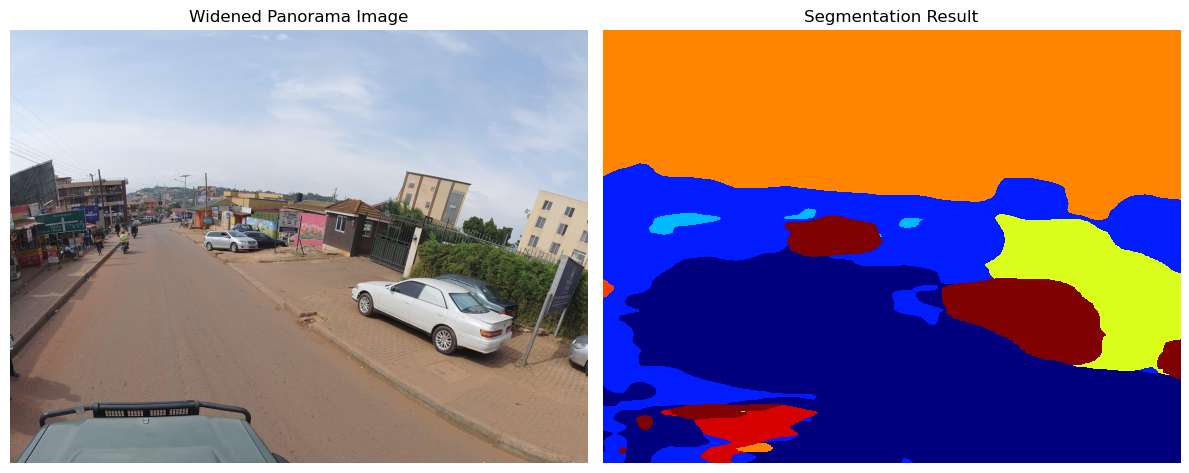

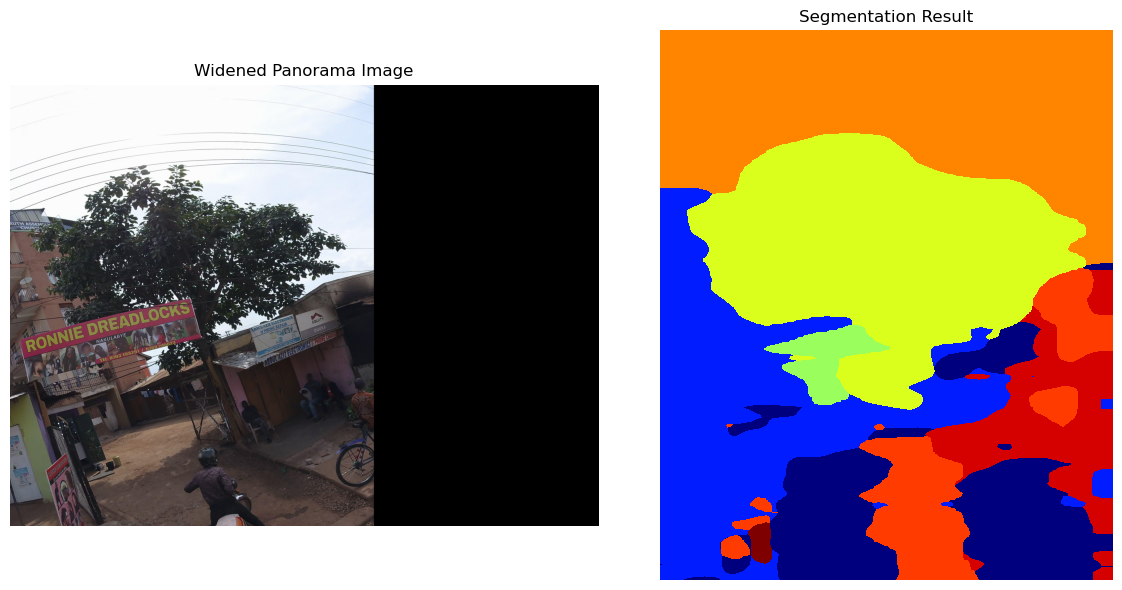

True

In [19]:
image_metadata = {"properties": {"id": "104291412342290", "is_pano": True}}
processor, model = get_models()

download_image(image_metadata, city, access_token, processor, model)